In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'ON Variation 6 LSTM Time Series'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## ON Semiconductor Corporation Stock Data

### No other stock price

In [5]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-05-22,22.7500,21.868590,-31.896552,-691100.0,2.0
2000-05-23,20.0000,21.581114,-67.289720,-1747800.0,2.0
2000-05-24,19.8750,21.318635,-69.158879,-3059300.0,2.0
2000-05-25,19.5000,21.038845,-74.766355,-3905000.0,2.0
2000-05-26,18.1875,20.600177,-94.392523,-4983300.0,1.0


In [6]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [7]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4661, 15, 4)

In [8]:
y = labels
y = np.array(y)
y.shape

(4661,)

In [9]:
from collections import Counter

Counter(y)

Counter({0.0: 198, 2.0: 4263, 1.0: 200})

In [10]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [11]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [12]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 2s 53ms/step - loss: 0.2925 - accuracy: 0.5003 - mse: 0.4600 - weighted_accuracy: 0.3118 - weighted_mse: 0.5447 - val_loss: 0.2993 - val_accuracy: 0.0429 - val_mse: 0.3551 - val_weighted_accuracy: 0.0429 - val_weighted_mse: 0.3551
Epoch 2/200
30/30 [==============================] - 1s 18ms/step - loss: 0.2084 - accuracy: 0.3635 - mse: 0.7923 - weighted_accuracy: 0.4721 - weighted_mse: 0.7679 - val_loss: 0.2908 - val_accuracy: 0.0429 - val_mse: 0.3867 - val_weighted_accuracy: 0.0429 - val_weighted_mse: 0.3867
Epoch 3/200
30/30 [==============================] - 1s 20ms/step - loss: 0.1846 - accuracy: 0.3222 - mse: 1.0322 - weighted_accuracy: 0.5291 - weighted_mse: 0.9959 - val_loss: 0.2804 - val_accuracy: 0.0429 - val_mse: 0.4268 - val_weighted_accuracy: 0.0429 - val_weighted_mse: 0.4268
Epoch 4/200
30/30 [==============================] - 1s 20ms/step - loss: 0.1765 - accuracy: 0.2720 - mse: 1.1804 - weighted_accuracy: 0.5429 - weig

Epoch 30/200
30/30 [==============================] - 1s 17ms/step - loss: 0.1335 - accuracy: 0.3978 - mse: 1.7326 - weighted_accuracy: 0.7086 - weighted_mse: 1.6600 - val_loss: 0.1774 - val_accuracy: 0.4577 - val_mse: 1.7280 - val_weighted_accuracy: 0.4577 - val_weighted_mse: 1.7280
Epoch 31/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1317 - accuracy: 0.4042 - mse: 1.7581 - weighted_accuracy: 0.7269 - weighted_mse: 1.6791 - val_loss: 0.1818 - val_accuracy: 0.4405 - val_mse: 1.6613 - val_weighted_accuracy: 0.4405 - val_weighted_mse: 1.6613
Epoch 32/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1320 - accuracy: 0.4386 - mse: 1.7460 - weighted_accuracy: 0.7314 - weighted_mse: 1.6812 - val_loss: 0.1750 - val_accuracy: 0.4630 - val_mse: 1.8117 - val_weighted_accuracy: 0.4630 - val_weighted_mse: 1.8117
Epoch 33/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1299 - accuracy: 0.4547 - mse: 1.7613 - weighted_accuracy: 0.7372 - 

Epoch 59/200
30/30 [==============================] - 1s 19ms/step - loss: 0.1094 - accuracy: 0.5883 - mse: 2.2172 - weighted_accuracy: 0.8139 - weighted_mse: 2.2247 - val_loss: 0.1788 - val_accuracy: 0.5295 - val_mse: 2.2909 - val_weighted_accuracy: 0.5295 - val_weighted_mse: 2.2909
Epoch 60/200
30/30 [==============================] - 1s 18ms/step - loss: 0.1070 - accuracy: 0.5759 - mse: 2.2664 - weighted_accuracy: 0.8133 - weighted_mse: 2.2632 - val_loss: 0.1804 - val_accuracy: 0.5016 - val_mse: 2.3789 - val_weighted_accuracy: 0.5016 - val_weighted_mse: 2.3789
Epoch 61/200
30/30 [==============================] - 1s 18ms/step - loss: 0.1067 - accuracy: 0.6065 - mse: 2.2583 - weighted_accuracy: 0.8226 - weighted_mse: 2.2749 - val_loss: 0.1601 - val_accuracy: 0.5863 - val_mse: 2.2921 - val_weighted_accuracy: 0.5863 - val_weighted_mse: 2.2921
Epoch 62/200
30/30 [==============================] - 1s 19ms/step - loss: 0.1080 - accuracy: 0.5716 - mse: 2.3313 - weighted_accuracy: 0.8078 - 

Epoch 88/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0912 - accuracy: 0.6545 - mse: 2.8123 - weighted_accuracy: 0.8661 - weighted_mse: 2.8343 - val_loss: 0.1667 - val_accuracy: 0.6131 - val_mse: 3.0168 - val_weighted_accuracy: 0.6131 - val_weighted_mse: 3.0168
Epoch 89/200
30/30 [==============================] - 0s 17ms/step - loss: 0.0894 - accuracy: 0.6993 - mse: 2.8619 - weighted_accuracy: 0.8804 - weighted_mse: 2.9350 - val_loss: 0.2110 - val_accuracy: 0.5188 - val_mse: 3.2543 - val_weighted_accuracy: 0.5188 - val_weighted_mse: 3.2543
Epoch 90/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0892 - accuracy: 0.6711 - mse: 2.9474 - weighted_accuracy: 0.8642 - weighted_mse: 3.0042 - val_loss: 0.1386 - val_accuracy: 0.6945 - val_mse: 3.2643 - val_weighted_accuracy: 0.6945 - val_weighted_mse: 3.2643
Epoch 91/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0878 - accuracy: 0.6875 - mse: 2.9146 - weighted_accuracy: 0.8721 - 

Epoch 117/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0785 - accuracy: 0.7387 - mse: 3.5670 - weighted_accuracy: 0.8928 - weighted_mse: 3.5955 - val_loss: 0.1581 - val_accuracy: 0.6742 - val_mse: 3.9746 - val_weighted_accuracy: 0.6742 - val_weighted_mse: 3.9746
Epoch 118/200
30/30 [==============================] - 1s 18ms/step - loss: 0.0741 - accuracy: 0.7264 - mse: 3.6477 - weighted_accuracy: 0.8943 - weighted_mse: 3.7051 - val_loss: 0.1392 - val_accuracy: 0.7556 - val_mse: 3.8749 - val_weighted_accuracy: 0.7556 - val_weighted_mse: 3.8749
Epoch 119/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0735 - accuracy: 0.7597 - mse: 3.6662 - weighted_accuracy: 0.8984 - weighted_mse: 3.7394 - val_loss: 0.1735 - val_accuracy: 0.6259 - val_mse: 3.8645 - val_weighted_accuracy: 0.6259 - val_weighted_mse: 3.8645
Epoch 120/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0731 - accuracy: 0.7629 - mse: 3.7819 - weighted_accuracy: 0.901

Epoch 146/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0659 - accuracy: 0.7945 - mse: 4.3921 - weighted_accuracy: 0.9171 - weighted_mse: 4.4458 - val_loss: 0.1593 - val_accuracy: 0.6924 - val_mse: 5.0029 - val_weighted_accuracy: 0.6924 - val_weighted_mse: 5.0029
Epoch 147/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0622 - accuracy: 0.7983 - mse: 4.4893 - weighted_accuracy: 0.9165 - weighted_mse: 4.5517 - val_loss: 0.1652 - val_accuracy: 0.6902 - val_mse: 4.7679 - val_weighted_accuracy: 0.6902 - val_weighted_mse: 4.7679
Epoch 148/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0609 - accuracy: 0.7969 - mse: 4.5022 - weighted_accuracy: 0.9160 - weighted_mse: 4.5282 - val_loss: 0.1463 - val_accuracy: 0.7738 - val_mse: 5.2714 - val_weighted_accuracy: 0.7738 - val_weighted_mse: 5.2714
Epoch 149/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0627 - accuracy: 0.7918 - mse: 4.6597 - weighted_accuracy: 0.916

Epoch 175/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0504 - accuracy: 0.8447 - mse: 5.3655 - weighted_accuracy: 0.9414 - weighted_mse: 5.3852 - val_loss: 0.1788 - val_accuracy: 0.7020 - val_mse: 5.3894 - val_weighted_accuracy: 0.7020 - val_weighted_mse: 5.3894
Epoch 176/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0484 - accuracy: 0.8495 - mse: 5.4849 - weighted_accuracy: 0.9392 - weighted_mse: 5.4648 - val_loss: 0.1853 - val_accuracy: 0.6988 - val_mse: 5.9248 - val_weighted_accuracy: 0.6988 - val_weighted_mse: 5.9248
Epoch 177/200
30/30 [==============================] - 0s 14ms/step - loss: 0.0491 - accuracy: 0.8619 - mse: 5.5892 - weighted_accuracy: 0.9417 - weighted_mse: 5.5855 - val_loss: 0.1949 - val_accuracy: 0.6720 - val_mse: 5.9700 - val_weighted_accuracy: 0.6720 - val_weighted_mse: 5.9700
Epoch 178/200
30/30 [==============================] - 0s 14ms/step - loss: 0.0484 - accuracy: 0.8484 - mse: 5.6067 - weighted_accuracy: 0.942

In [16]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2100219577550888
Test accuracy: 0.6816720366477966


In [17]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.9304221  -4.5886955   1.5381504 ]
 [-2.6602848  -2.885787    2.4703336 ]
 [-2.6201391  -0.76570994 -0.20913358]
 ...
 [-3.3036108   0.11902211 -0.78602767]
 [ 0.58566046 -5.7943463  -1.1361638 ]
 [-2.7059557  -0.09419905 -0.61527866]]


Counter({2: 681, 1: 146, 0: 106})

In [18]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 853, 0: 40, 1: 40})

In [19]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 933
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 31
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 31
actual holds but predicted buy: 136
actual holds but predicted sell: 98
actual predicted holds: 619
Percentage buys correct: 22.5%
Percentage sells correct: 20.0%
Percentage holds correct: 72.56740914419696%
actual buys: 40
actual sells: 40
actual holds: 853


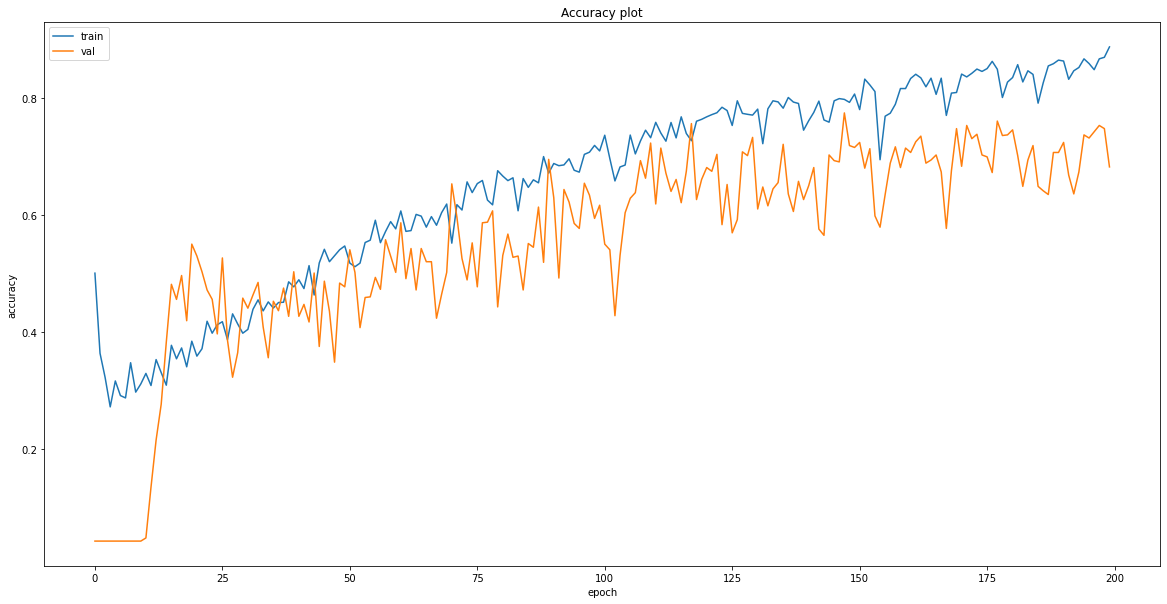

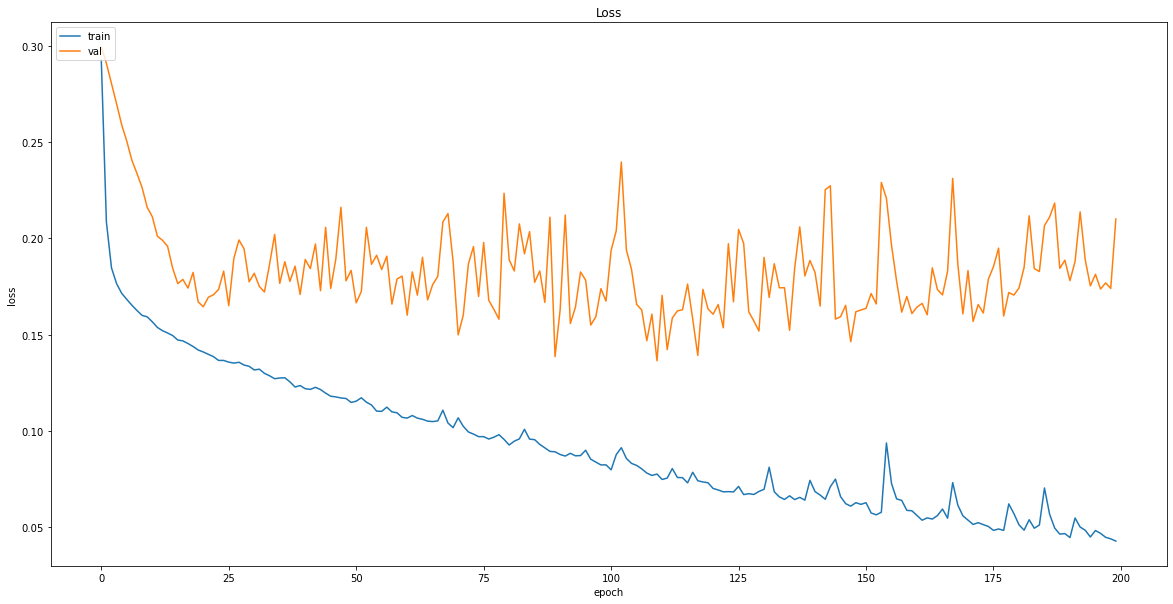

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
# Save model
model.save("models/{}".format('ON_no_support_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/ON_no_support_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### Non-Recession Test Data

In [22]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [23]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,18.410000,17.463881,-16.959062,38067400.0,2.0
2019-01-23,17.760000,17.509437,-35.964898,32120500.0,1.0
2019-01-24,17.610001,17.524909,-40.350852,27571200.0,2.0
2019-01-25,18.990000,17.750307,-5.688638,39283300.0,2.0
2019-01-28,20.120001,18.114876,-3.499985,49475700.0,2.0


In [24]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [25]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [26]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [27]:
model = tf.keras.models.load_model("models/ON_no_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.2157 - accuracy: 0.6606 - mean_squared_error: 7.2474 - weighted_accuracy: 0.6606 - weighted_mean_squared_error: 7.2474
Test loss: 0.21572932600975037
Test accuracy: 0.6605504751205444


In [28]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 156, 0: 23, 1: 39})

In [29]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 198, 0: 10, 1: 10})

In [30]:
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test.csv")
df.set_index('Date', inplace=True)

In [31]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-08,21.84,20.674019,-18.092112,89360900.0,2.0,2,2
2019-02-11,22.24,20.853401,-24.835530,80357300.0,2.0,2,2
2019-02-12,22.73,21.066723,-18.256589,87641400.0,2.0,0,2
2019-02-13,22.93,21.322612,-11.610502,92339900.0,2.0,0,2
2019-02-14,22.91,21.569903,-9.790209,98060800.0,2.0,0,0


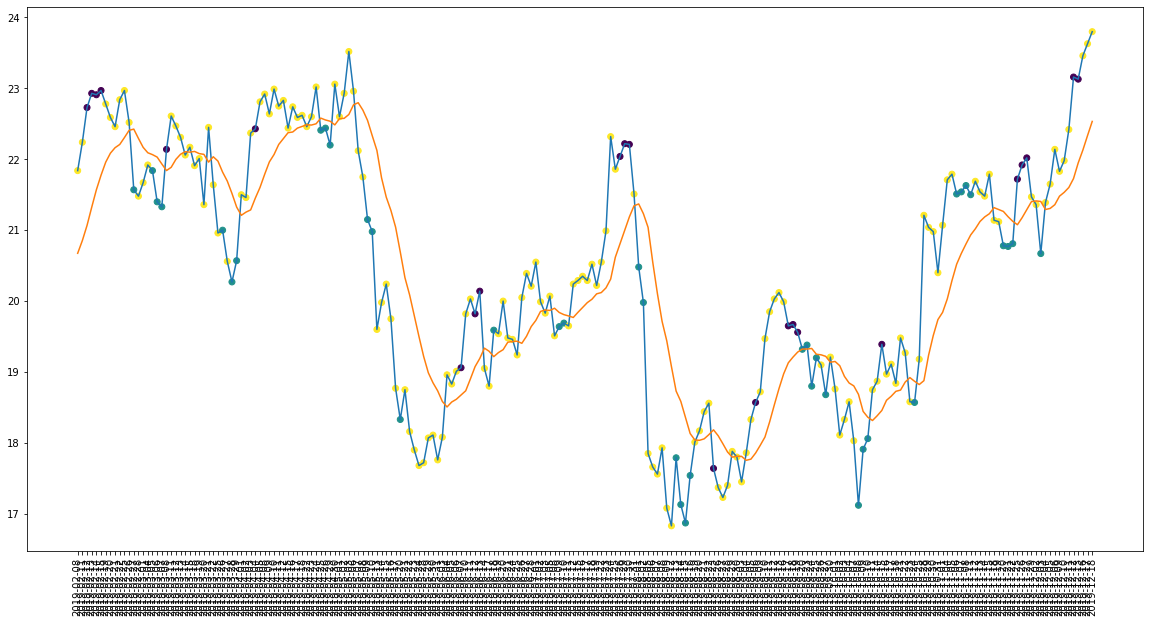

In [32]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [33]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 38
actual holds but predicted sell: 20
actual predicted holds: 140
Percentage buys correct: 10.0%
Percentage sells correct: 30.0%
Percentage holds correct: 70.70707070707071%
actual buys: 10
actual sells: 10
actual holds: 198


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[21.84000015258789, 22.239999771118164, 22.459999084472656, 22.59000015258789, 22.729999542236328, 22.78000068664551, 22.90999984741211, 22.93000030517578, 22.96999931335449]
[21.479999542236328, 21.56999969482422, 21.670000076293945, 22.459999084472656, 22.520000457763672, 22.59000015258789, 22.78000068664551, 22.84000015258789, 22.96999931335449]
Percentage buys correct: 71.7948717948718%
Percentage sells correct: 65.21739130434783%
Percentage holds correct: 83.97435897435898%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $21.56999969482422
Shares owned at the moment: 462
Cash capital at the moment: $7.255456378936287


Stop Loss Activated!

Share price: $20.959999084472656
Shares owned at the moment: 0
Cash capital at the moment: $9664.14535456848


Share price: $21.0
Shares owned at the moment: 458
Cash capital at the moment: $19.695854568479263


Stop Loss Activated!

Share price: $20.270000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9277.825998647688


Share price: $20.270000457763672
Shares owned at the moment: 456
Cash capital at the moment: $9.287209333417195


Price increase from previously bought: 10.352671242549505%
Share price: $22.43000030517578
Shares owned at the moment: 0
Cash capital at the moment: $10209.240128110883


Share price: $22.40999984741211
Shares owned at the moment: 454
Cash capital at the moment: $7.12131257629153


Stop Loss Activated!

Share price: $21.75
Shares owned at the moment: 0
Cash capital at the moment: $9854.466437576291


S

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10836.527023284913
profit gained: 8.365270232849124%


In [37]:
logger

[0.6605504751205444,
 '10.0%',
 '30.0%',
 '70.70707070707071%',
 '71.7948717948718%',
 '65.21739130434783%',
 '83.97435897435898%',
 '18.095076895537296%',
 '8.365270232849124%']

In [38]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.66055,10.0%,30.0%,70.70707070707071%,71.7948717948718%,65.21739130434783%,83.97435897435898%,18.095076895537296%,8.365270232849124%


### Recession Test Data

In [39]:
logger = []

In [40]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    24.790001  24.846573 -58.549170  15793400.0     2.0
2020-01-23    24.799999  24.839408 -58.031122  19314300.0     2.0
2020-01-24    25.469999  24.936422 -23.316098  25250200.0     2.0
2020-01-27    24.990000  24.944665 -48.186537  19824200.0     2.0
2020-01-28    23.660000  24.747024 -96.170207  12158200.0     2.0


In [41]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [42]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [43]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [44]:
model = tf.keras.models.load_model("models/ON_no_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 5ms/step - loss: 0.1823 - accuracy: 0.6941 - mean_squared_error: 6.3135 - weighted_accuracy: 0.6941 - weighted_mean_squared_error: 6.3135
Test loss: 0.18229378759860992
Test accuracy: 0.6940639019012451


In [45]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 161, 0: 36, 1: 22})

In [46]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [47]:
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test2.csv")
df.set_index('Date', inplace=True)

In [48]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-10,20.540001,22.132652,-82.137401,-44701000.0,2.0,2,2
2020-02-11,21.400000,21.887629,-80.763353,-38050800.0,2.0,2,2
2020-02-12,21.389999,21.812609,-67.633600,-29835300.0,2.0,2,0
2020-02-13,21.629999,21.747592,-67.786276,-35158900.0,0.0,0,2
2020-02-14,21.440001,21.729501,-53.280337,-29027400.0,2.0,2,2


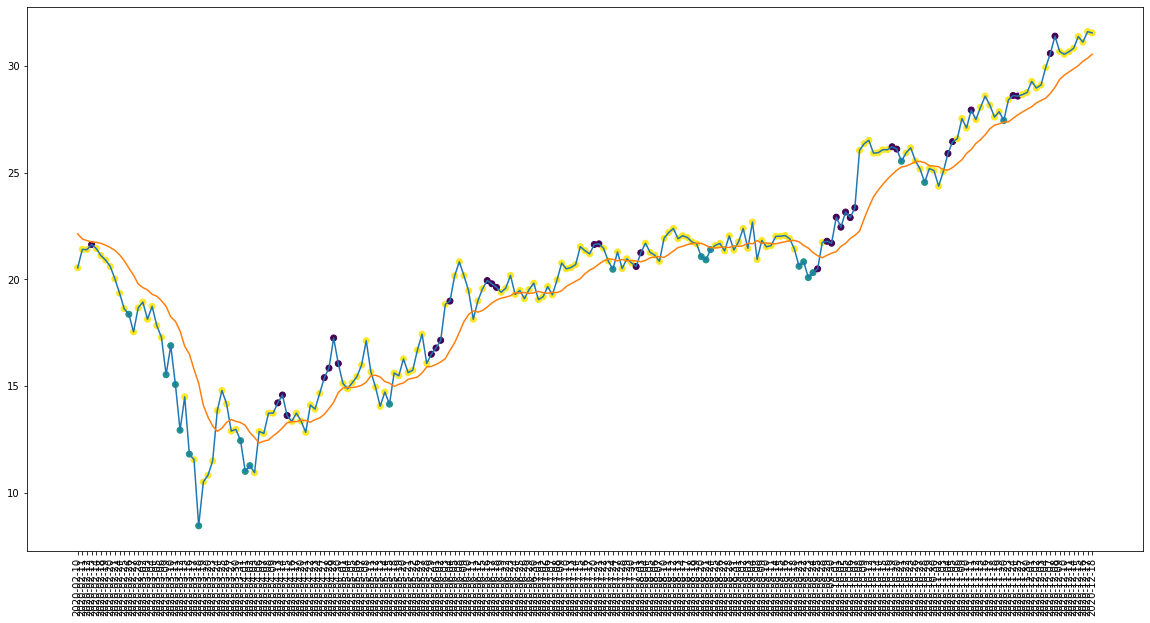

In [49]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [50]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))
logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 19
actual holds but predicted sell: 33
actual predicted holds: 146
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 30.0%
Percentage holds correct: 73.73737373737374%
actual buys: 11
actual sells: 10
actual holds: 198


In [51]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[20.020000457763672, 20.540000915527344, 20.600000381469727, 20.899999618530273, 21.11000061035156, 21.38999938964844, 21.399999618530273, 21.440000534057614, 21.6299991607666]
[17.540000915527347, 18.36000061035156, 18.6200008392334, 18.65999984741211, 18.93000030517578, 19.350000381469727, 20.020000457763672, 20.600000381469727, 20.899999618530273]
Percentage buys correct: 81.81818181818181%
Percentage sells correct: 61.111111111111114%
Percentage holds correct: 85.71428571428571%


In [52]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $18.36000061035156
Shares owned at the moment: 543
Cash capital at the moment: $3.1035976676957944


Stop Loss Activated!

Share price: $17.540000915527347
Shares owned at the moment: 0
Cash capital at the moment: $9501.132488431933


Share price: $15.529999732971193
Shares owned at the moment: 610
Cash capital at the moment: $1.7810767674454837


Stop Loss Activated!

Share price: $15.06999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9169.200966122153


Share price: $15.06999969482422
Shares owned at the moment: 606
Cash capital at the moment: $11.666996567249953


Stop Loss Activated!

Share price: $12.93000030517578
Shares owned at the moment: 0
Cash capital at the moment: $7825.699335995197


Share price: $12.93000030517578
Shares owned at the moment: 603
Cash capital at the moment: $7.467978968143143


Stop Loss Activated!

Share price: $11.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7109.314298801183


Share price:

In [53]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15265.53829755783
profit gained: 52.655382975578306%


In [54]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.660550,10.0%,30.0%,70.70707070707071%,71.7948717948718%,65.21739130434783%,83.97435897435898%,18.095076895537296%,8.365270232849124%
1,0.694064,27.272727272727273%,30.0%,73.73737373737374%,81.81818181818181%,61.111111111111114%,85.71428571428571%,15.333263080646976%,52.655382975578306%


### with TSM stock price

In [55]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-05-22,22.7500,21.868590,-31.896552,-691100.0,2.0
2000-05-23,20.0000,21.581114,-67.289720,-1747800.0,2.0
2000-05-24,19.8750,21.318635,-69.158879,-3059300.0,2.0
2000-05-25,19.5000,21.038845,-74.766355,-3905000.0,2.0
2000-05-26,18.1875,20.600177,-94.392523,-4983300.0,1.0


In [56]:
df2 = pd.read_csv("data/variation 6/initial_indicators/TSM_data.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,19.949877,19.054130,-24.858793,6410264.0,2.0
2000-01-24,20.708067,19.308582,-12.499994,8519498.0,2.0
2000-01-25,22.627235,19.819144,-9.615394,11923394.0,2.0
2000-01-26,24.830727,20.590156,-1.204825,15511940.0,2.0
2000-01-27,23.977762,21.111327,-32.407403,8331683.0,2.0


In [57]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2000-05-22,22.7500,21.868590,-31.896552,-691100.0,18.105579,2.0
2000-05-23,20.0000,21.581114,-67.289720,-1747800.0,17.468700,2.0
2000-05-24,19.8750,21.318635,-69.158879,-3059300.0,16.831820,2.0
2000-05-25,19.5000,21.038845,-74.766355,-3905000.0,16.012976,2.0
2000-05-26,18.1875,20.600177,-94.392523,-4983300.0,16.043303,1.0


In [58]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [59]:
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(4661, 15, 5)

In [60]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [61]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [62]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [64]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 47ms/step - loss: 0.2957 - accuracy: 0.5598 - mse: 0.4297 - weighted_accuracy: 0.3057 - weighted_mse: 0.5235 - val_loss: 0.3013 - val_accuracy: 0.0397 - val_mse: 0.3545 - val_weighted_accuracy: 0.0397 - val_weighted_mse: 0.3545
Epoch 2/200
30/30 [==============================] - 0s 12ms/step - loss: 0.2142 - accuracy: 0.4185 - mse: 0.7360 - weighted_accuracy: 0.4299 - weighted_mse: 0.7329 - val_loss: 0.2926 - val_accuracy: 0.0429 - val_mse: 0.3792 - val_weighted_accuracy: 0.0429 - val_weighted_mse: 0.3792
Epoch 3/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1895 - accuracy: 0.3608 - mse: 0.9735 - weighted_accuracy: 0.4931 - weighted_mse: 0.9484 - val_loss: 0.2800 - val_accuracy: 0.0429 - val_mse: 0.4089 - val_weighted_accuracy: 0.0429 - val_weighted_mse: 0.4089
Epoch 4/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1798 - accuracy: 0.3015 - mse: 1.1389 - weighted_accuracy: 0.5256 - weig

Epoch 30/200
30/30 [==============================] - 1s 17ms/step - loss: 0.1280 - accuracy: 0.4300 - mse: 1.7506 - weighted_accuracy: 0.7463 - weighted_mse: 1.7046 - val_loss: 0.1822 - val_accuracy: 0.4062 - val_mse: 1.7195 - val_weighted_accuracy: 0.4062 - val_weighted_mse: 1.7195
Epoch 31/200
30/30 [==============================] - 1s 19ms/step - loss: 0.1260 - accuracy: 0.4077 - mse: 1.7775 - weighted_accuracy: 0.7562 - weighted_mse: 1.7097 - val_loss: 0.1937 - val_accuracy: 0.3869 - val_mse: 1.8312 - val_weighted_accuracy: 0.3869 - val_weighted_mse: 1.8312
Epoch 32/200
30/30 [==============================] - 1s 18ms/step - loss: 0.1247 - accuracy: 0.4506 - mse: 1.7687 - weighted_accuracy: 0.7598 - weighted_mse: 1.7154 - val_loss: 0.1805 - val_accuracy: 0.4244 - val_mse: 1.9097 - val_weighted_accuracy: 0.4244 - val_weighted_mse: 1.9097
Epoch 33/200
30/30 [==============================] - 1s 19ms/step - loss: 0.1226 - accuracy: 0.4855 - mse: 1.7633 - weighted_accuracy: 0.7705 - 

Epoch 59/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0952 - accuracy: 0.6601 - mse: 2.4437 - weighted_accuracy: 0.8661 - weighted_mse: 2.5476 - val_loss: 0.1845 - val_accuracy: 0.5091 - val_mse: 2.6823 - val_weighted_accuracy: 0.5091 - val_weighted_mse: 2.6823
Epoch 60/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0925 - accuracy: 0.6427 - mse: 2.4993 - weighted_accuracy: 0.8638 - weighted_mse: 2.6034 - val_loss: 0.1723 - val_accuracy: 0.5477 - val_mse: 2.6207 - val_weighted_accuracy: 0.5477 - val_weighted_mse: 2.6207
Epoch 61/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0915 - accuracy: 0.6650 - mse: 2.5324 - weighted_accuracy: 0.8659 - weighted_mse: 2.6598 - val_loss: 0.1595 - val_accuracy: 0.6056 - val_mse: 2.6866 - val_weighted_accuracy: 0.6056 - val_weighted_mse: 2.6866
Epoch 62/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0918 - accuracy: 0.6709 - mse: 2.5779 - weighted_accuracy: 0.8760 - 

Epoch 88/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0711 - accuracy: 0.7530 - mse: 3.4039 - weighted_accuracy: 0.9100 - weighted_mse: 3.5316 - val_loss: 0.1543 - val_accuracy: 0.6774 - val_mse: 3.6983 - val_weighted_accuracy: 0.6774 - val_weighted_mse: 3.6983
Epoch 89/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0680 - accuracy: 0.7977 - mse: 3.4953 - weighted_accuracy: 0.9183 - weighted_mse: 3.7186 - val_loss: 0.1837 - val_accuracy: 0.5938 - val_mse: 3.8845 - val_weighted_accuracy: 0.5938 - val_weighted_mse: 3.8845
Epoch 90/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0686 - accuracy: 0.7790 - mse: 3.5589 - weighted_accuracy: 0.9175 - weighted_mse: 3.7523 - val_loss: 0.1492 - val_accuracy: 0.6838 - val_mse: 3.8993 - val_weighted_accuracy: 0.6838 - val_weighted_mse: 3.8993
Epoch 91/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0670 - accuracy: 0.7916 - mse: 3.5890 - weighted_accuracy: 0.9200 - 

Epoch 117/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0571 - accuracy: 0.8361 - mse: 4.9160 - weighted_accuracy: 0.9263 - weighted_mse: 5.0377 - val_loss: 0.1790 - val_accuracy: 0.6334 - val_mse: 5.1550 - val_weighted_accuracy: 0.6334 - val_weighted_mse: 5.1550
Epoch 118/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0529 - accuracy: 0.8275 - mse: 4.9389 - weighted_accuracy: 0.9351 - weighted_mse: 5.0981 - val_loss: 0.1487 - val_accuracy: 0.7460 - val_mse: 5.2308 - val_weighted_accuracy: 0.7460 - val_weighted_mse: 5.2308
Epoch 119/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0500 - accuracy: 0.8527 - mse: 4.9696 - weighted_accuracy: 0.9423 - weighted_mse: 5.1022 - val_loss: 0.1748 - val_accuracy: 0.6795 - val_mse: 5.6024 - val_weighted_accuracy: 0.6795 - val_weighted_mse: 5.6024
Epoch 120/200
30/30 [==============================] - 0s 17ms/step - loss: 0.0488 - accuracy: 0.8608 - mse: 5.1496 - weighted_accuracy: 0.949

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0441 - accuracy: 0.8777 - mse: 5.9906 - weighted_accuracy: 0.9554 - weighted_mse: 6.1212 - val_loss: 0.1694 - val_accuracy: 0.7224 - val_mse: 6.7008 - val_weighted_accuracy: 0.7224 - val_weighted_mse: 6.7008
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0408 - accuracy: 0.8930 - mse: 6.1561 - weighted_accuracy: 0.9610 - weighted_mse: 6.2645 - val_loss: 0.1650 - val_accuracy: 0.7406 - val_mse: 6.4361 - val_weighted_accuracy: 0.7406 - val_weighted_mse: 6.4361
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0401 - accuracy: 0.8857 - mse: 6.0982 - weighted_accuracy: 0.9563 - weighted_mse: 6.1327 - val_loss: 0.1635 - val_accuracy: 0.7449 - val_mse: 6.6074 - val_weighted_accuracy: 0.7449 - val_weighted_mse: 6.6074
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0461 - accuracy: 0.8664 - mse: 6.1485 - weighted_accuracy: 0.9513 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9152 - mse: 7.5820 - weighted_accuracy: 0.9671 - weighted_mse: 7.4821 - val_loss: 0.1911 - val_accuracy: 0.7492 - val_mse: 8.0594 - val_weighted_accuracy: 0.7492 - val_weighted_mse: 8.0594
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 0.9182 - mse: 7.5414 - weighted_accuracy: 0.9662 - weighted_mse: 7.3908 - val_loss: 0.1966 - val_accuracy: 0.7395 - val_mse: 8.2285 - val_weighted_accuracy: 0.7395 - val_weighted_mse: 8.2285
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0300 - accuracy: 0.9227 - mse: 7.7498 - weighted_accuracy: 0.9718 - weighted_mse: 7.4947 - val_loss: 0.1834 - val_accuracy: 0.7599 - val_mse: 8.4586 - val_weighted_accuracy: 0.7599 - val_weighted_mse: 8.4586
Epoch 178/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0302 - accuracy: 0.9270 - mse: 7.8599 - weighted_accuracy: 0.9714 - 

In [65]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2037552297115326
Test accuracy: 0.7427652478218079


In [66]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.7173716  -3.2527773   1.2591329 ]
 [-0.99905324 -2.4700878   0.12909314]
 [-4.353355   -1.6133145   0.76394415]
 ...
 [-2.8798296  -1.3042189   0.15046561]
 [-0.6147762  -3.9421167  -0.2136665 ]
 [-5.5320067  -0.9766152   0.11551049]]


Counter({2: 754, 1: 114, 0: 65})

In [67]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 853, 0: 40, 1: 40})

In [68]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 933
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 33
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 37
actual holds but predicted buy: 106
actual holds but predicted sell: 63
actual predicted holds: 684
Percentage buys correct: 17.5%
Percentage sells correct: 5.0%
Percentage holds correct: 80.18757327080891%
actual buys: 40
actual sells: 40
actual holds: 853


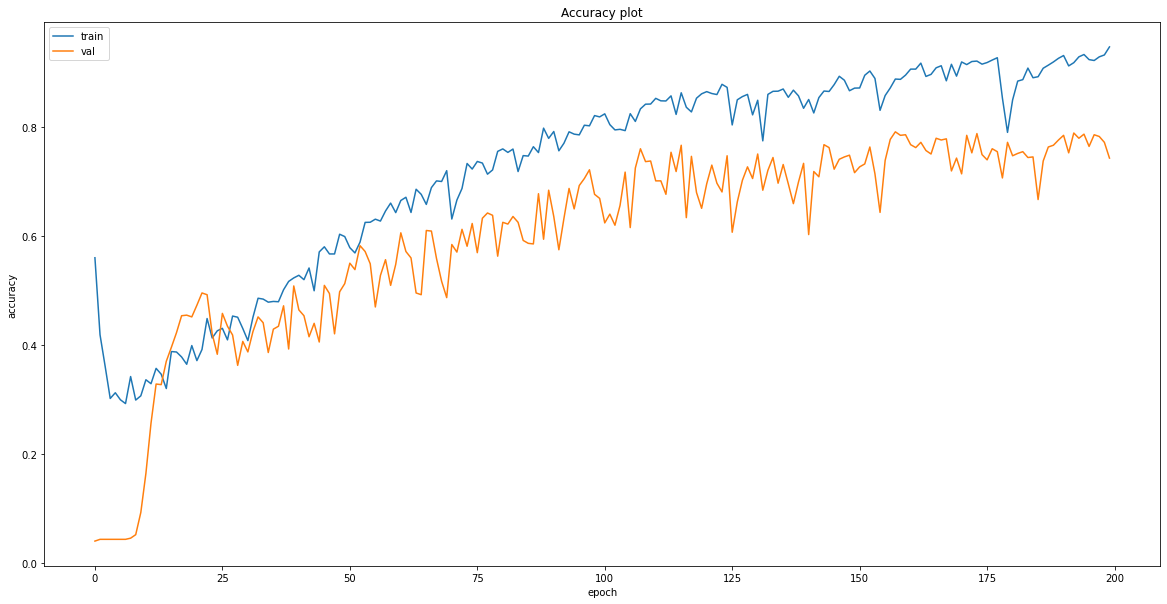

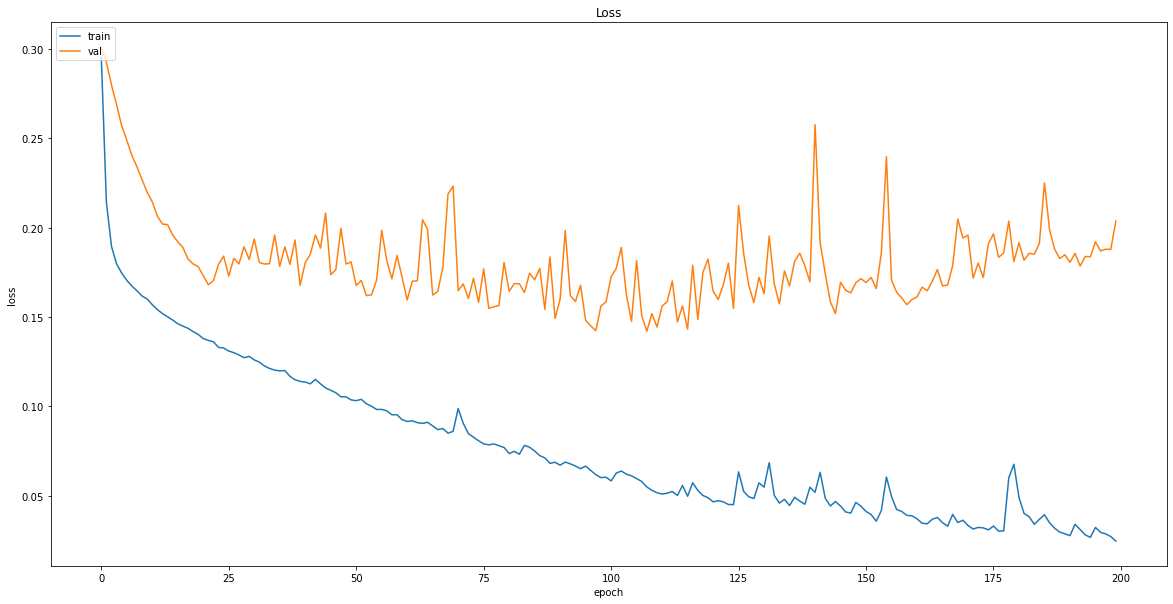

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
# Save model
model.save("models/{}".format('ON_support_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/ON_support_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### non-recession

In [71]:
logger = []

In [72]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    18.410000  17.463881 -16.959062  38067400.0     2.0
2019-01-23    17.760000  17.509437 -35.964898  32120500.0     1.0
2019-01-24    17.610001  17.524909 -40.350852  27571200.0     2.0
2019-01-25    18.990000  17.750307  -5.688638  39283300.0     2.0
2019-01-28    20.120001  18.114876  -3.499985  49475700.0     2.0


In [73]:
df2 = pd.read_csv("data/variation 6/initial_indicators/TSM_data_test.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,36.840000,35.988585,-22.189342,49908500.0,2.0
2019-01-23,36.369999,36.047264,-22.857127,36526800.0,2.0
2019-01-24,36.490002,36.115377,-18.571314,50445400.0,2.0
2019-01-25,37.639999,36.349935,-0.000000,64539500.0,2.0
2019-01-28,38.139999,36.625329,-3.314889,81303200.0,2.0


In [74]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2019-01-22,18.410000,17.463881,-16.959062,38067400.0,36.840000,2.0
2019-01-23,17.760000,17.509437,-35.964898,32120500.0,36.369999,1.0
2019-01-24,17.610001,17.524909,-40.350852,27571200.0,36.490002,2.0
2019-01-25,18.990000,17.750307,-5.688638,39283300.0,37.639999,2.0
2019-01-28,20.120001,18.114876,-3.499985,49475700.0,38.139999,2.0


In [75]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [76]:
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(218, 15, 5)

In [77]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [78]:
model = tf.keras.models.load_model("models/ON_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2230 - accuracy: 0.7615 - mean_squared_error: 9.4387 - weighted_accuracy: 0.7615 - weighted_mean_squared_error: 9.4387
Test loss: 0.22299033403396606
Test accuracy: 0.7614678740501404


In [79]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 178, 0: 14, 1: 26})

In [80]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 198, 0: 10, 1: 10})

In [81]:
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test.csv")
df.set_index('Date', inplace=True)

In [82]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,22.240000,20.853401,-24.835530,80357300.0,2.0,2,2
2019-02-12,22.730000,21.066723,-18.256589,87641400.0,2.0,2,2
2019-02-13,22.930000,21.322612,-11.610502,92339900.0,2.0,2,2
2019-02-14,22.910000,21.569903,-9.790209,98060800.0,2.0,2,2
2019-02-15,22.969999,21.776071,-10.731719,93565600.0,0.0,0,0


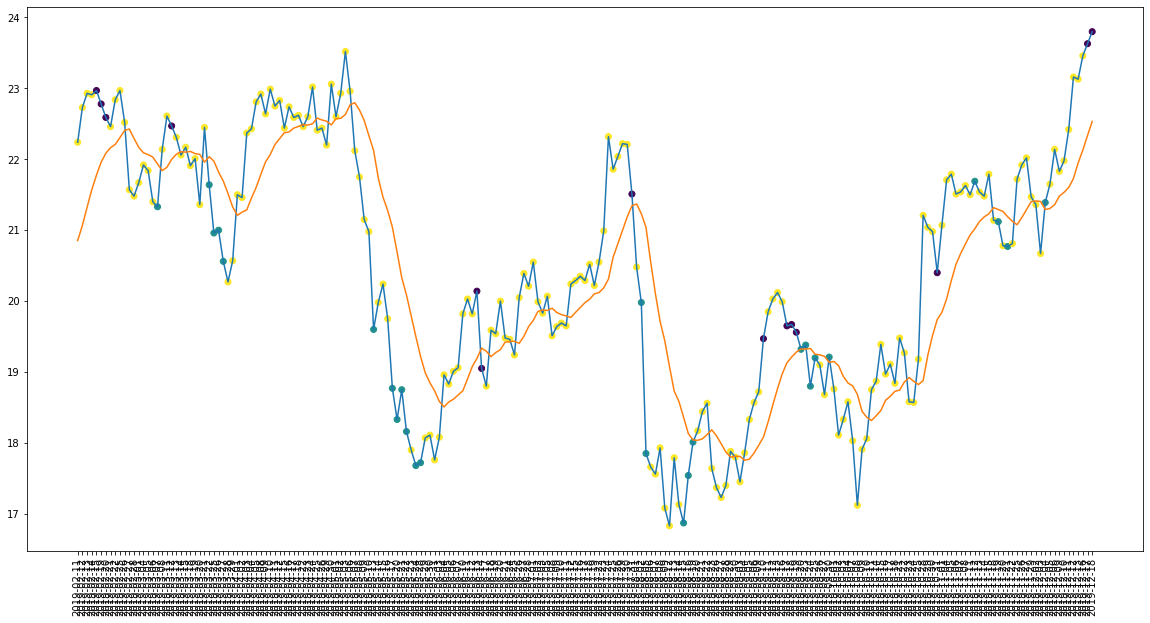

In [83]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

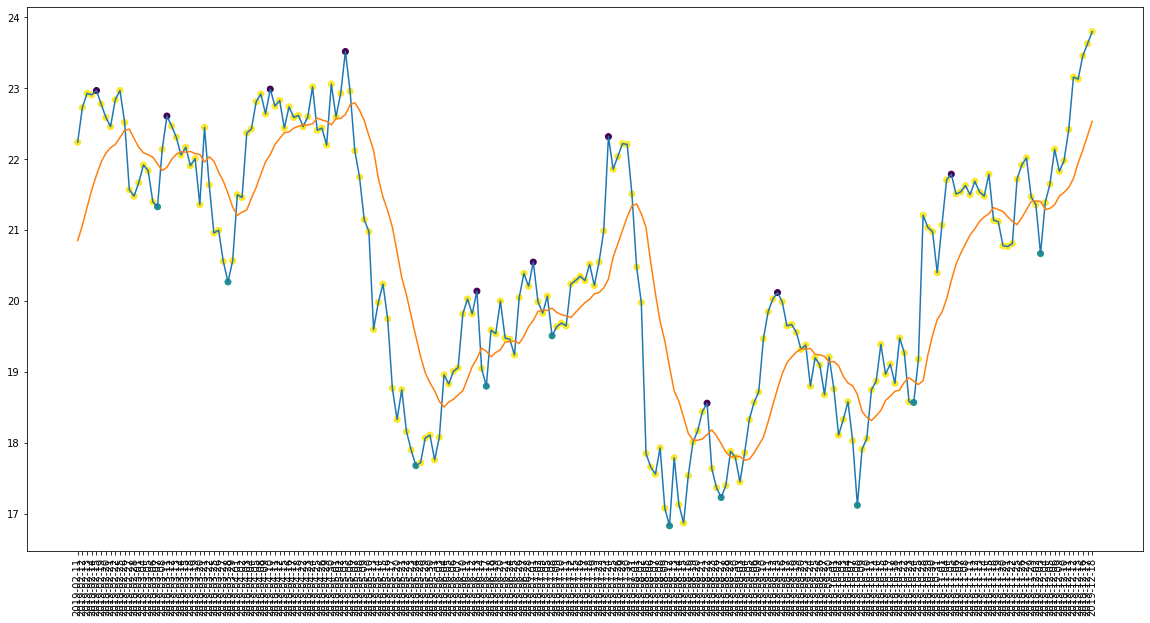

In [84]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [85]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 24
actual holds but predicted sell: 12
actual predicted holds: 162
Percentage buys correct: 20.0%
Percentage sells correct: 20.0%
Percentage holds correct: 81.81818181818181%
actual buys: 10
actual sells: 10
actual holds: 198


In [86]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[22.239999771118164, 22.459999084472656, 22.59000015258789, 22.729999542236328, 22.78000068664551, 22.84000015258789, 22.90999984741211, 22.93000030517578, 22.96999931335449]
[21.479999542236328, 21.56999969482422, 21.670000076293945, 21.920000076293945, 22.459999084472656, 22.520000457763672, 22.59000015258789, 22.84000015258789, 22.96999931335449]
Percentage buys correct: 57.69230769230769%
Percentage sells correct: 42.857142857142854%
Percentage holds correct: 84.7457627118644%


In [87]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $21.32999992370605
Shares owned at the moment: 467
Cash capital at the moment: $11.496983227254532


Price increase from previously bought: 5.0556791314556815%
Share price: $22.46999931335449
Shares owned at the moment: 0
Cash capital at the moment: $10476.129565945625


Share price: $21.63999938964844
Shares owned at the moment: 482
Cash capital at the moment: $16.966040944096676


Stop Loss Activated!

Share price: $20.959999084472656
Shares owned at the moment: 0
Cash capital at the moment: $10091.903120873449


Share price: $20.959999084472656
Shares owned at the moment: 480
Cash capital at the moment: $3.4363615350703185


Stop Loss Activated!

Share price: $20.270000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9706.280180657384


Share price: $19.600000381469727
Shares owned at the moment: 493
Cash capital at the moment: $16.90729207563163


Stop Loss Activated!

Share price: $18.770000457763672
Shares owned at the moment: 0
Cash capital at th

In [88]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10642.158481964114
profit gained: 6.421584819641139%


In [89]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.660550,10.0%,30.0%,70.70707070707071%,71.7948717948718%,65.21739130434783%,83.97435897435898%,18.095076895537296%,8.365270232849124%
1,0.694064,27.272727272727273%,30.0%,73.73737373737374%,81.81818181818181%,61.111111111111114%,85.71428571428571%,15.333263080646976%,52.655382975578306%
2,0.761468,20.0%,20.0%,81.81818181818181%,57.69230769230769%,42.857142857142854%,84.7457627118644%,-7.467419904060479%,6.421584819641139%


### recession test data

In [90]:
logger = []

In [91]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    24.790001  24.846573 -58.549170  15793400.0     2.0
2020-01-23    24.799999  24.839408 -58.031122  19314300.0     2.0
2020-01-24    25.469999  24.936422 -23.316098  25250200.0     2.0
2020-01-27    24.990000  24.944665 -48.186537  19824200.0     2.0
2020-01-28    23.660000  24.747024 -96.170207  12158200.0     2.0


In [92]:
df2 = pd.read_csv("data/variation 6/initial_indicators/TSM_data_test2.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-22,58.240002,58.725183,-61.538439,1540100.0,2.0
2020-01-23,58.349998,58.667462,-58.718007,9664600.0,2.0
2020-01-24,57.480000,58.484776,-78.606952,-334600.0,2.0
2020-01-27,57.730000,58.368656,-72.388048,10067600.0,2.0
2020-01-28,55.259998,57.890401,-96.415824,392100.0,2.0


In [93]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2020-01-22,24.790001,24.846573,-58.549170,15793400.0,58.240002,2.0
2020-01-23,24.799999,24.839408,-58.031122,19314300.0,58.349998,2.0
2020-01-24,25.469999,24.936422,-23.316098,25250200.0,57.480000,2.0
2020-01-27,24.990000,24.944665,-48.186537,19824200.0,57.730000,2.0
2020-01-28,23.660000,24.747024,-96.170207,12158200.0,55.259998,2.0


In [94]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(219, 15, 5)

In [95]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [96]:
model = tf.keras.models.load_model("models/ON_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2213 - accuracy: 0.7854 - mean_squared_error: 8.3317 - weighted_accuracy: 0.7854 - weighted_mean_squared_error: 8.3317
Test loss: 0.2212577611207962
Test accuracy: 0.7853881120681763


In [97]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 189, 1: 14, 0: 16})

In [98]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [99]:
df = pd.read_csv("data/variation 6/initial_indicators/ON_data_test2.csv")
df.set_index('Date', inplace=True)

In [100]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,21.400000,21.887629,-80.763353,-38050800.0,2.0,2,2
2020-02-12,21.389999,21.812609,-67.633600,-29835300.0,2.0,2,2
2020-02-13,21.629999,21.747592,-67.786276,-35158900.0,0.0,2,0
2020-02-14,21.440001,21.729501,-53.280337,-29027400.0,2.0,2,2
2020-02-18,21.110001,21.684962,-57.057647,-34656200.0,2.0,2,2


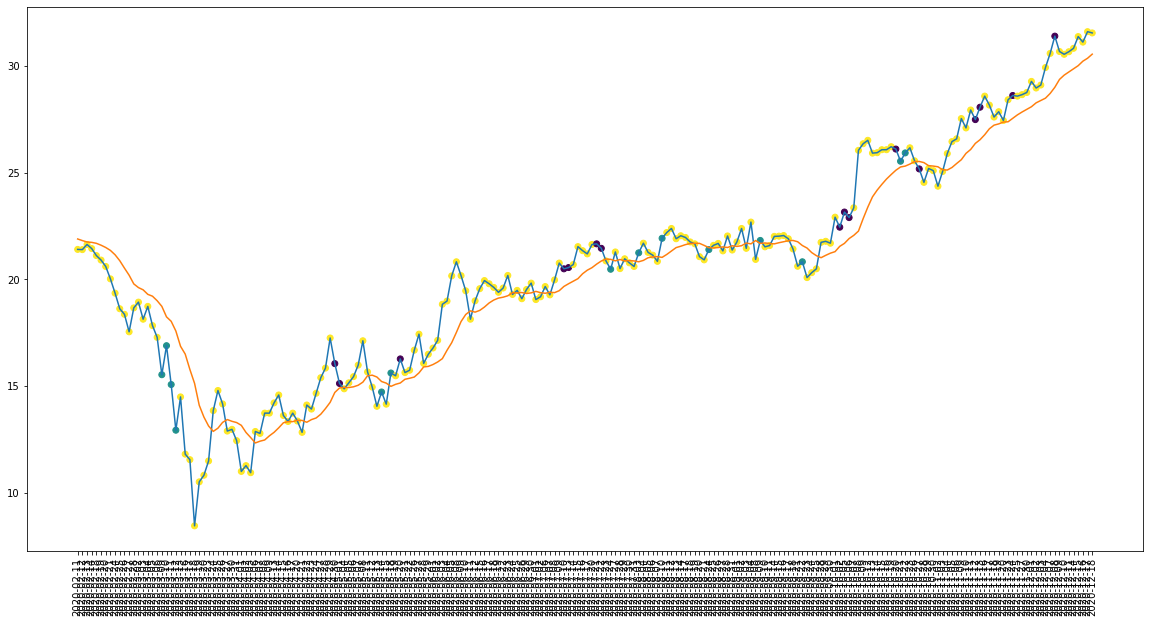

In [101]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

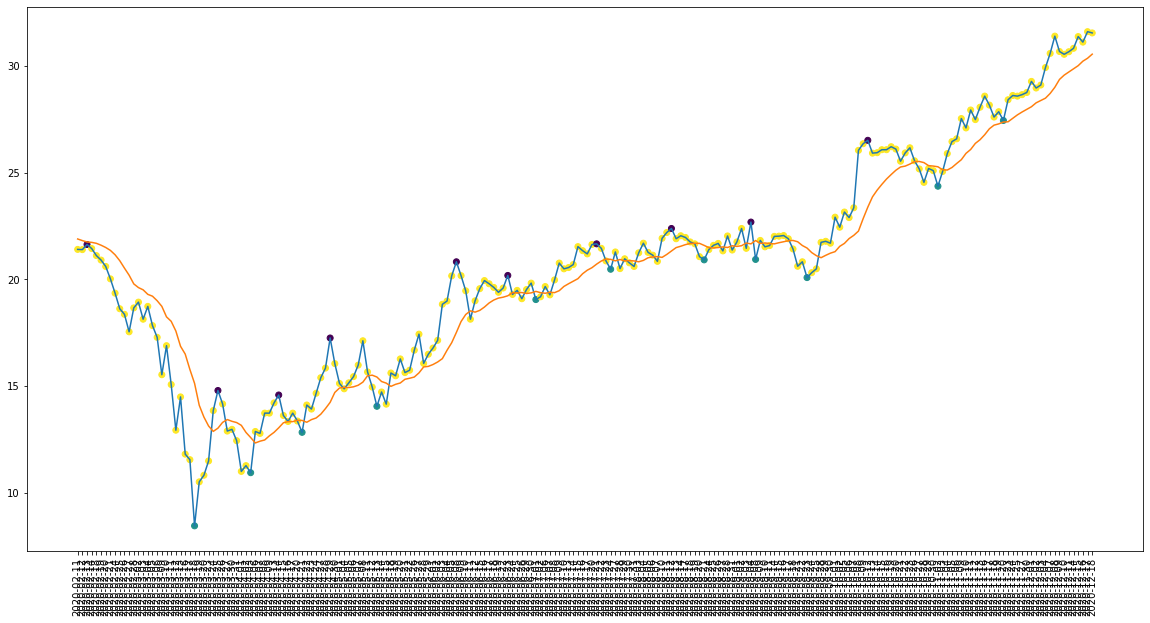

In [102]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [103]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 13
actual holds but predicted sell: 15
actual predicted holds: 170
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 10.0%
Percentage holds correct: 85.85858585858585%
actual buys: 11
actual sells: 10
actual holds: 198


In [104]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[19.350000381469727, 20.020000457763672, 20.600000381469727, 20.899999618530273, 21.11000061035156, 21.38999938964844, 21.399999618530273, 21.440000534057614, 21.6299991607666]
[17.540000915527347, 18.1299991607666, 18.36000061035156, 18.6200008392334, 18.65999984741211, 18.93000030517578, 19.350000381469727, 20.020000457763672, 20.600000381469727]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 56.25%
Percentage holds correct: 82.44680851063829%


In [105]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $15.529999732971193
Shares owned at the moment: 642
Cash capital at the moment: $2.321956903932005


Stop Loss Activated!

Share price: $15.06999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9650.65567651987


Share price: $15.06999969482422
Shares owned at the moment: 638
Cash capital at the moment: $9.555556757446539


Stop Loss Activated!

Share price: $12.93000030517578
Shares owned at the moment: 0
Cash capital at the moment: $8236.210065924162


Share price: $12.93000030517578
Shares owned at the moment: 635
Cash capital at the moment: $3.0808591046297806


Stop Loss Activated!

Share price: $11.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7481.807912328478


Share price: $14.720000267028807
Shares owned at the moment: 506
Cash capital at the moment: $13.00489684033073


Stop Loss Activated!

Share price: $14.149999618530273
Shares owned at the moment: 0
Cash capital at the moment: $7153.214979347464


Share price: $

In [106]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $14657.397993716238
profit gained: 46.573979937162385%


In [107]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.660550,10.0%,30.0%,70.70707070707071%,71.7948717948718%,65.21739130434783%,83.97435897435898%,18.095076895537296%,8.365270232849124%
1,0.694064,27.272727272727273%,30.0%,73.73737373737374%,81.81818181818181%,61.111111111111114%,85.71428571428571%,15.333263080646976%,52.655382975578306%
2,0.761468,20.0%,20.0%,81.81818181818181%,57.69230769230769%,42.857142857142854%,84.7457627118644%,-7.467419904060479%,6.421584819641139%
3,0.785388,9.090909090909092%,10.0%,85.85858585858585%,42.857142857142854%,56.25%,82.44680851063829%,-2.7366078174329416%,46.573979937162385%


In [108]:
experiment

'ON Variation 6 LSTM Time Series'

In [109]:
log.to_csv('{}.csv'.format(experiment))